In [1]:
import pandas as pd
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

# Consumption Data

In [3]:
# read from csv into a new dataframe
raw = pd.read_csv('energy_raw.csv',index_col=0,na_values=['#########'])

# reindex by appropriate datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# remove built-in demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# rename columns accordingly
raw.columns = buildingnames

In [4]:
# save the first five rows to replace later
raw_head = raw.head(1)
raw.describe()
raw_head

,YUAG,Berkeley,Hopper,304Elm,Davenport,38HH,320Temple,53Wall,Sprague,Malone,Trumbull,17HH
2018-01-01,7929946.5,7241231.2,2766963.5,1109119.8,4306847.8,3164052.8,94018.2,3024576.8,358345.5,6543549.3,4441711.2,8929603.5


In [5]:
# remove impossible outliers based on the percent change, limited by tau
raw = raw.where(raw.pct_change(limit=1)>0)

# tau = 0.0005 * (raw.max()-raw.min())
# raw = raw.where(raw.pct_change(limit=1)<tau)

# replace consumption head before calculating demand
raw.iloc[[0],:] = raw_head

raw.isnull().sum()

YUAG         109
Berkeley       3
Hopper         3
304Elm       109
Davenport    906
38HH           3
320Temple    118
53Wall       212
Sprague        4
Malone       109
Trumbull     172
17HH         254
dtype: int64

In [6]:
# interpolates small ranges of missing consumption data (less than 6 hours)
# raw = raw.interpolate(method='time',limit=6,limit_area='inside')

# fn.plot_all(raw,'2018-06-14 00:00:00','2018-06-20 00:00:00')
raw.isnull().sum()

YUAG         109
Berkeley       3
Hopper         3
304Elm       109
Davenport    906
38HH           3
320Temple    118
53Wall       212
Sprague        4
Malone       109
Trumbull     172
17HH         254
dtype: int64

# Demand Data

YUAG         127
Berkeley       5
Hopper         5
304Elm       127
Davenport    908
38HH           5
320Temple    140
53Wall       331
Sprague        7
Malone       127
Trumbull     251
17HH         413
dtype: int64

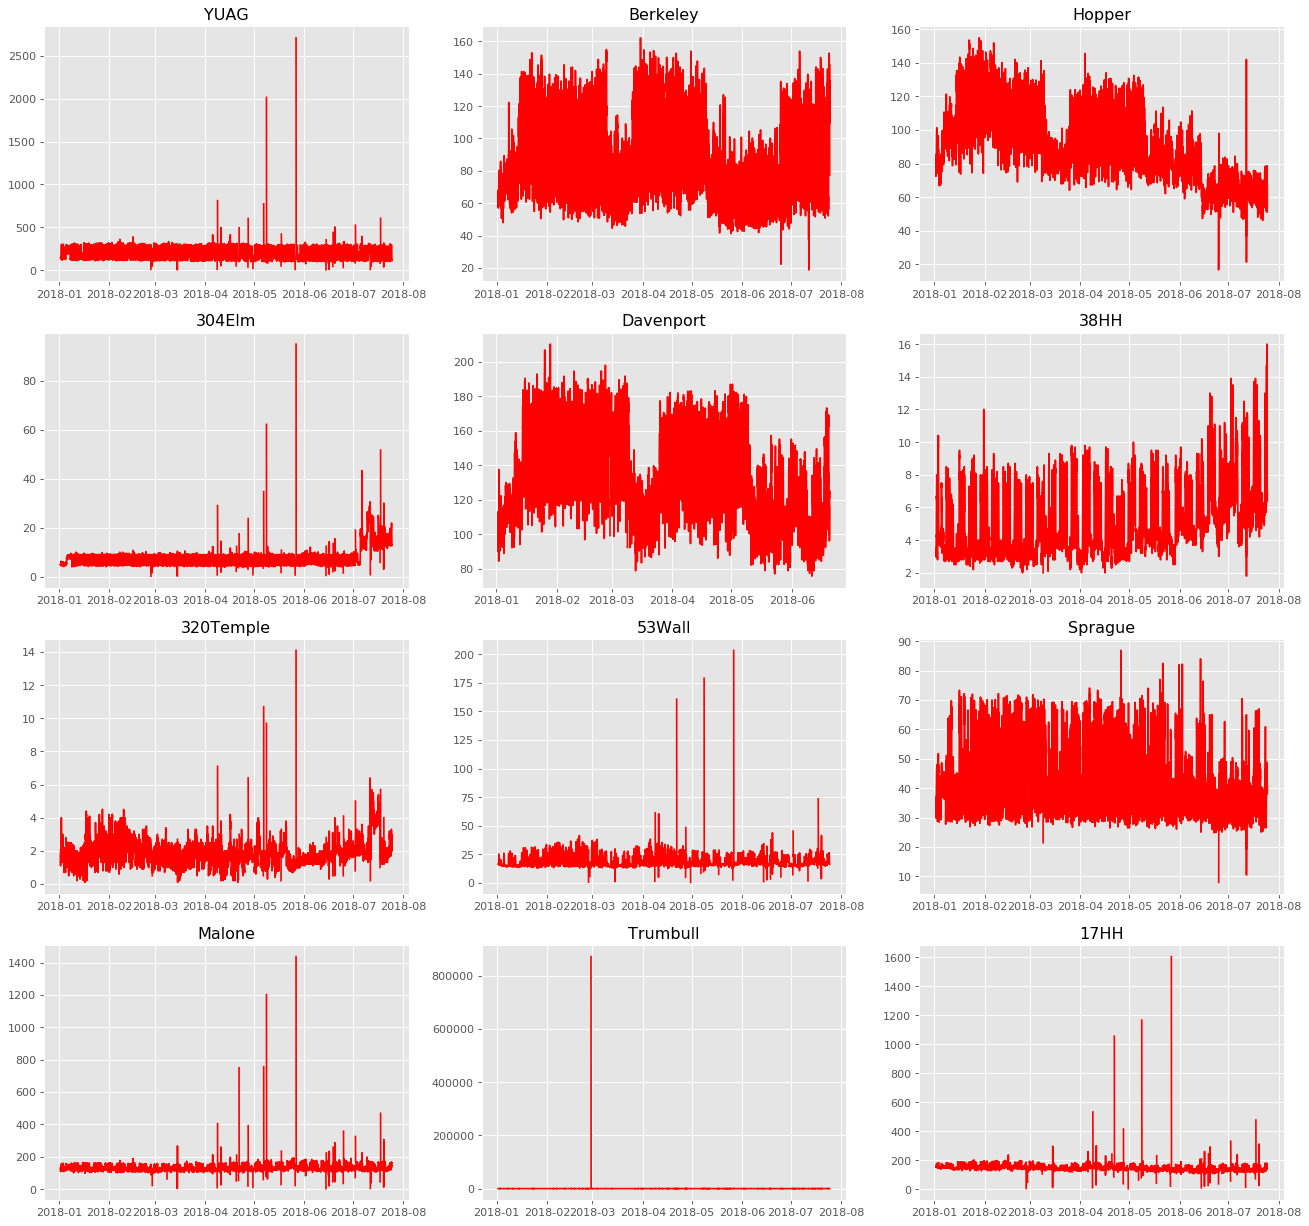

In [7]:
# creates a new dataframe for the demand values, drops the first row
demand = raw.diff().drop(raw.index[0])

# saves head to replace later
demand_head = demand.head(5)

fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
demand.isnull().sum()

In [8]:
# remove large statistical outliers
# demand = demand.where(demand > demand.median() - 4*demand.std())
# demand = demand.where(demand < demand.median() + 10*demand.std())

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

/Users/kevinkoste/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7772: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors, try_cast=try_cast)


YUAG          156
Berkeley       10
Hopper         10
304Elm        230
Davenport     908
38HH            7
320Temple     197
53Wall       1609
Sprague         9
Malone        164
Trumbull      285
17HH         2357
dtype: int64

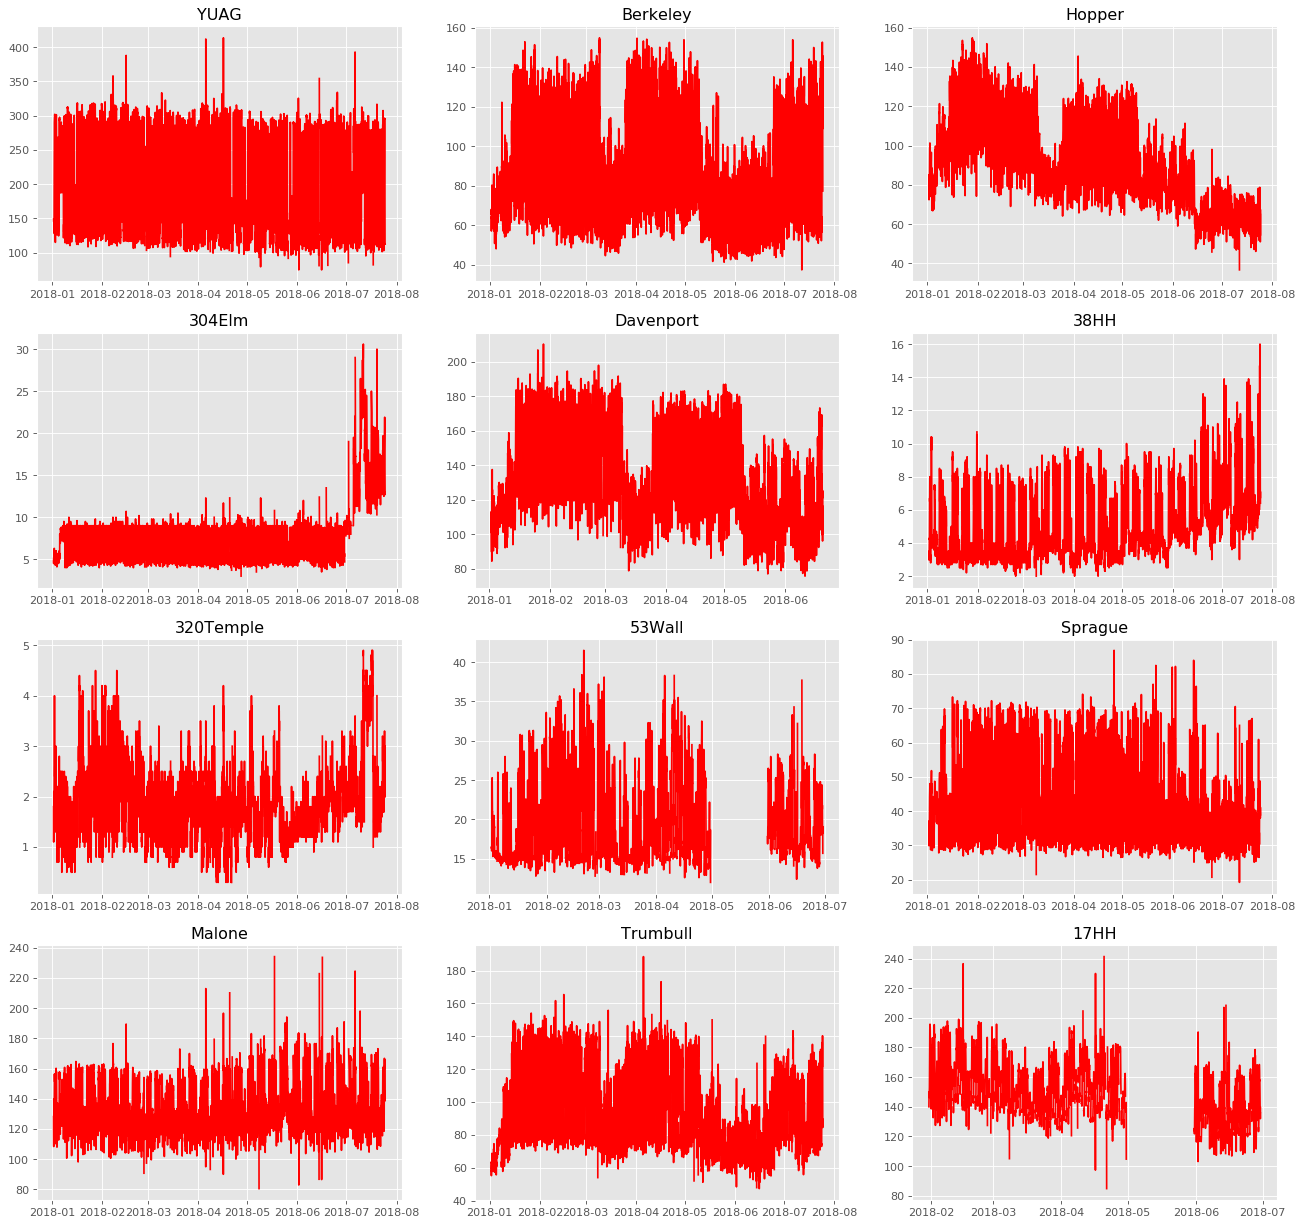

In [9]:
# working pretty damn well, now implement on a monthly basis to handle changes like in hopper, berkeley
# last thing to try is .where(demand < demand.pct_change * some factor... or rolling pct change?)


chunk_size = 720
i=0

while i < len(demand):
    end = i+chunk_size
    if end > len(demand): end = len(demand)
    demand[i:end].where(demand[i:end] > demand[i:end].rolling(72).min().median()*0.7, inplace=True)
    demand[i:end].where(demand[i:end] < demand[i:end].rolling(72).max().median()*1.4, inplace=True)
    i = i+chunk_size

fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
demand.isnull().sum()

In [10]:
# comp = demand.take([1], axis=1)
# comp['rolling'] = comp.loc[:,'Berkeley'].rolling(4,min_periods=1).median()
# # demand.rolling(4,min_periods=1).median()*0.5

# comp['rollmin'] = comp.loc[:,'Berkeley'].rolling(8,min_periods=6).min()

# # fn.plot_all(comp,'2018-03-14 00:00:00','2018-06-20 00:00:00')

# fn.plot_feature(comp,'rollmin','2018-01-02 00:00:00','2018-07-25 00:00:00')

# comp['rollmin'].median()-comp['rollmin'].std()

# max_tuner = 1 # here i want higher values clipping more points
# min_tuner = 1

# # demand.std()/demand.median() # here high values indicate volatile, 

# demand = demand.where(demand > demand.rolling(8,min_periods=4).min() - (min_tuner - demand.std()/demand.median()))
                      
# demand = demand.where(demand < demand.rolling(8,min_periods=4).max() + (max_tuner - demand.std()/demand.median()))


# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()

In [11]:
# def rolling_clean(df,col)

#     for i in range(len(df)):
#         if df < df.rolling(5).median()*0.6:
#             slope = [(df[i+2]) - (df[i-1])]/3
#             df = [(df[i] + (df[i+1]))/2] - slope
#             df[i+1] = df[i] + 2*slope


# # another try, use larger window but the mean
# # demand = demand.where(demand > demand.rolling(5).mean()*0.3).where(demand < demand.rolling(5).mean()*2)

# fn.plot_all(demand,'2018-03-14 00:00:00','2018-06-20 00:00:00')
# demand.isnull().sum()

YUAG          156
Berkeley       10
Hopper         10
304Elm        230
Davenport     908
38HH            7
320Temple     197
53Wall       1609
Sprague         9
Malone        164
Trumbull      285
17HH         2357
dtype: int64

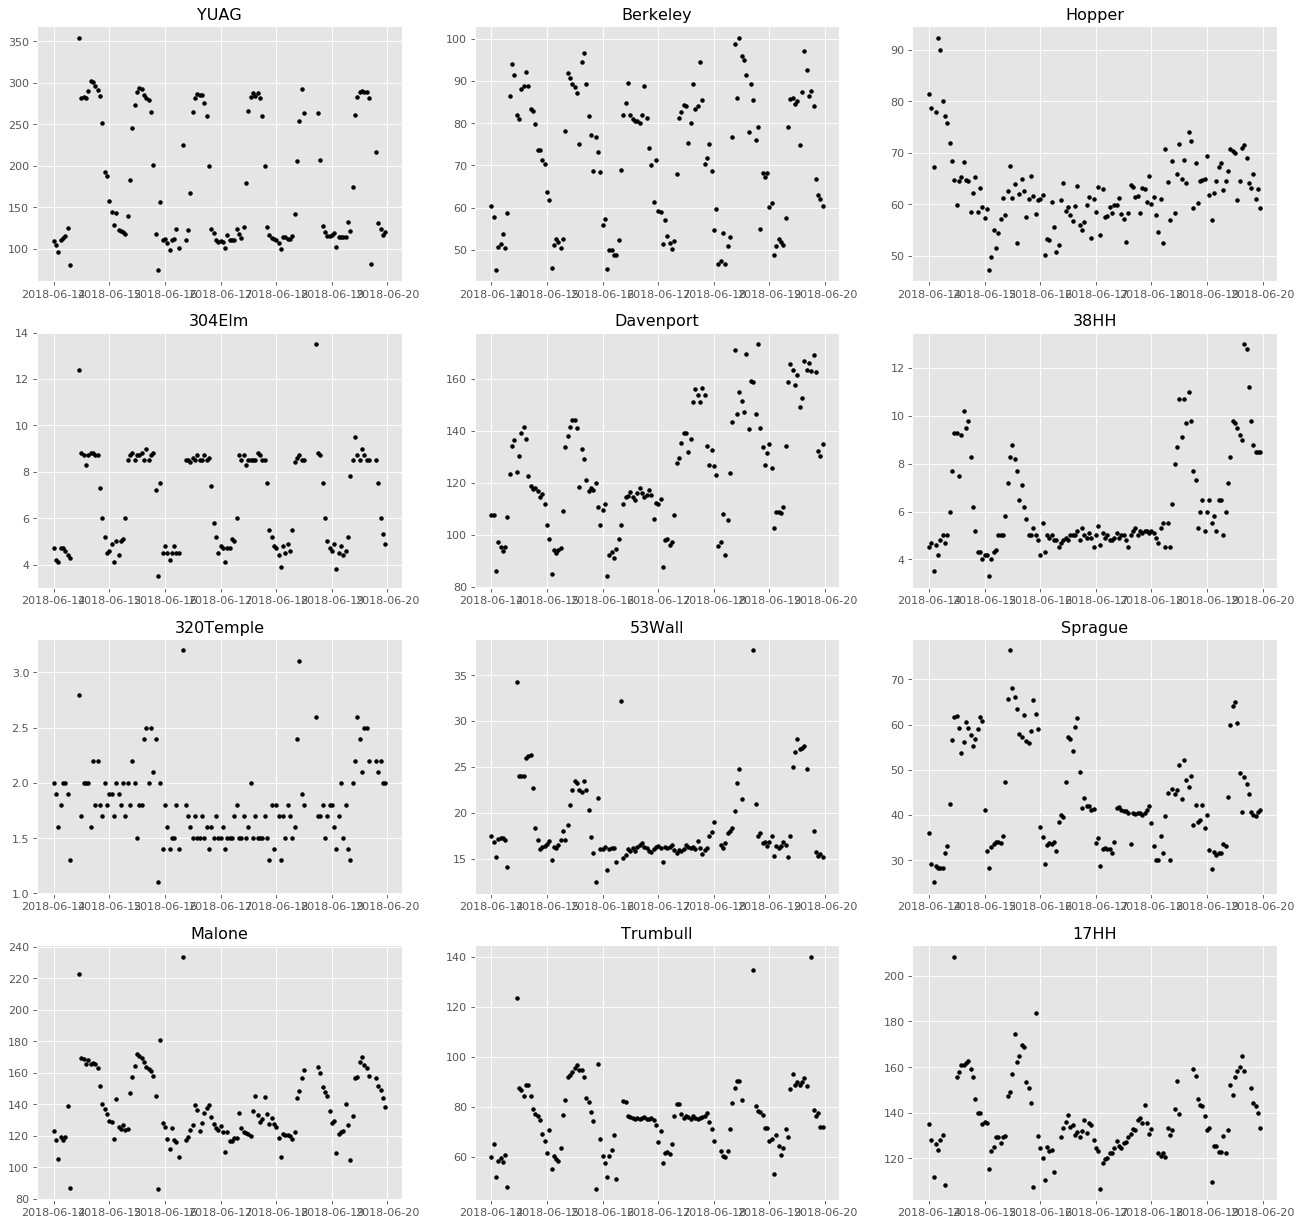

In [12]:
# interpolate, leaving 74 missing??? check locations.
# demand = demand.interpolate(method='time',limit=6)

fn.plot_all(demand,'2018-06-14 00:00:00','2018-06-20 00:00:00',style='k.')
demand.isnull().sum()

In [13]:
nan_index = demand['YUAG'].index[demand['YUAG'].apply(np.isnan)]
print(nan_index)

DatetimeIndex(['2018-02-26 15:00:00', '2018-02-26 16:00:00',
               '2018-02-26 17:00:00', '2018-02-26 18:00:00',
               '2018-02-26 19:00:00', '2018-02-26 20:00:00',
               '2018-02-26 21:00:00', '2018-02-26 22:00:00',
               '2018-02-26 23:00:00', '2018-02-27 00:00:00',
               ...
               '2018-07-12 02:00:00', '2018-07-12 03:00:00',
               '2018-07-17 16:00:00', '2018-07-17 17:00:00',
               '2018-07-17 18:00:00', '2018-07-17 19:00:00',
               '2018-07-17 20:00:00', '2018-07-17 21:00:00',
               '2018-07-17 22:00:00', '2018-07-19 20:00:00'],
              dtype='datetime64[ns]', length=156, freq=None)


YUAG          156
Berkeley       10
Hopper         10
304Elm        230
Davenport     908
38HH            7
320Temple     197
53Wall       1609
Sprague         9
Malone        164
Trumbull      285
17HH         2357
dtype: int64

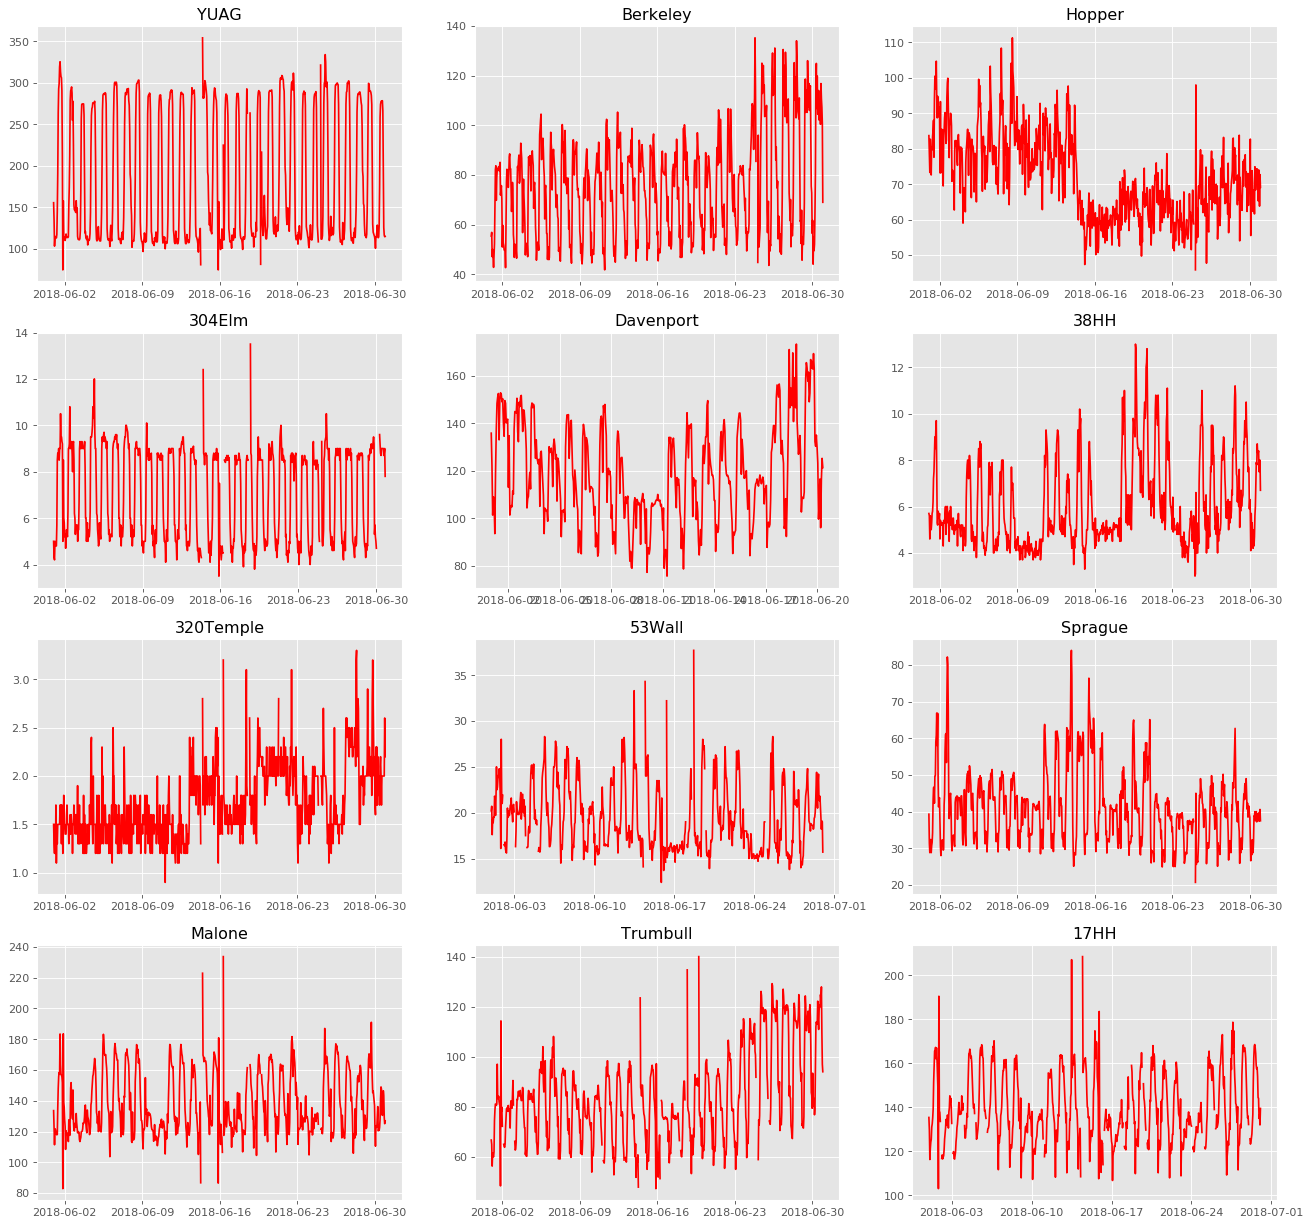

In [14]:
fn.plot_all(demand,'2018-06-01 00:00:00','2018-07-01 00:00:00')
demand.isnull().sum()

In [15]:
demand.describe()

,YUAG,Berkeley,Hopper,304Elm,Davenport,38HH,320Temple,53Wall,Sprague,Malone,Trumbull,17HH
count,4834.000000,4980.000000,4980.000000,4760.000000,4082.000000,4983.000000,4793.000000,3381.000000,4981.000000,4826.000000,4705.000000,2633.000000
mean,192.123521,90.560522,92.662269,8.051387,137.708501,5.228678,1.896265,19.914315,45.222967,135.591794,98.719830,152.146411
std,77.810792,27.102633,22.391483,3.676449,27.260592,2.151041,0.718650,5.200580,12.287593,17.826257,24.552214,18.520300
min,74.800000,37.300000,36.700000,3.000000,75.600000,2.000000,0.300000,12.000000,19.200000,80.500000,47.300000,84.800000
25%,121.600000,67.675000,75.500000,5.000000,115.900000,3.500000,1.400000,15.500000,34.400000,121.100000,78.000000,137.800000
50%,150.850000,85.500000,89.550000,8.500000,135.500000,4.500000,1.800000,18.200000,43.000000,131.500000,95.300000,150.500000
75%,283.300000,115.000000,110.425000,9.000000,162.300000,6.700000,2.300000,23.700000,54.300000,150.400000,120.600000,164.800000
max,413.700000,155.000000,154.800000,30.600000,210.400000,16.000000,4.900000,41.500000,86.900000,234.200000,188.500000,241.300000


In [16]:
# final interpolation of demand values after dropping outliers
# this needs to be replaced with FFT for any gaps longer than ~6 hours
demand = demand.interpolate(method='time',limit=24)

print(demand.isnull().sum())

# returns index labels where nan values appear for a certain column
nan_index = demand['304Elm'].index[demand['304Elm'].apply(np.isnan)]
print(nan_index)

YUAG            0
Berkeley        0
Hopper          0
304Elm         11
Davenport     879
38HH            0
320Temple       0
53Wall       1362
Sprague         0
Malone          0
Trumbull        0
17HH         2081
dtype: int64
DatetimeIndex(['2018-07-04 21:00:00', '2018-07-04 22:00:00',
               '2018-07-04 23:00:00', '2018-07-05 00:00:00',
               '2018-07-05 01:00:00', '2018-07-05 02:00:00',
               '2018-07-05 03:00:00', '2018-07-05 04:00:00',
               '2018-07-05 05:00:00', '2018-07-05 06:00:00',
               '2018-07-05 07:00:00'],
              dtype='datetime64[ns]', freq=None)


In [17]:
# replace head for final export
demand.iloc[[0,1,2,3,4],:] = demand_head

# final = demand.copy(deep=True).round(1)

final.to_csv('energy_clean.csv')

NameError: name 'final' is not defined

# unused code below

In [ ]:
# # this cell removes all consumption values BELOW first value

# # creates dataframe of repeated minimum (first) values, pretty workaroundy
# raw_mins = raw.copy(deep=True)
# raw_mins.loc[:,:] = raw.loc['2018-01-01 00:00:00'].values

# # sets all violating values to NaN
# raw = raw.where(raw >= raw_mins)

# # this unused line was an attempt to find outliers using std ranges
# # raw = raw.where(raw > raw.median() - 2*raw.std()).where(raw < raw.median() + 2*raw.std())

# raw.isnull().sum()

In [ ]:
# trying to plot daily average curves for buildings... matplotlib might support this somehow or i can write a fn

# raw = raw.iloc[:,[0]]

# raw['day'] = raw.index.day
# raw['hour'] = raw.index.hour

# raw_by_day = raw.resample('h').mean()
# raw_by_day = raw_by_day.set_index(['day','hour']).unstack('day')
# raw_by_day